Extract mel-spectrogram from audio

In [1]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from keras.preprocessing import image
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, TimeDistributed, LSTM, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss
from tensorflow.keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping


import os
import glob
import matplotlib.pyplot as plt


Find graphic specs

In [2]:
def load_data(dir_path):
    X = []
    y = []
    labels = ['PD', 'HC']
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = img_to_array(load_img(os.path.join(path, img), target_size=(640, 480)))  # Convert image to array
                X.append(preprocess_input(img_arr))  # Preprocess the image using VGG16's preprocess_input method
                y.append(class_num)
            except Exception as e:
                print(e)
    try:
        return np.array(X), np.array(y)
    except Exception as e:
        print(f'Failed to create numpy arrays: {e}')
        return None, None
X, y = load_data('./plots/')
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)

(160, 640, 480, 3)


train

In [3]:

# Reshape the data for LSTM
num_subjects_train = 32  
num_subjects_test = 8  # 20% of 40 subjects
num_observations_per_example = 5 
X_train = X_train.reshape((num_subjects_train, num_observations_per_example, 640, 480, 3))
X_test = X_test.reshape((num_subjects_test, num_observations_per_example, 640, 480, 3))
y_train = y_train.reshape((num_subjects_train, num_observations_per_example))
y_test = y_test.reshape(num_subjects_test, num_observations_per_example)


In [4]:
# Define ResNet model
resnet_model = ResNet50(weights='imagenet', include_top=False)

for layer in resnet_model.layers:
    layer.trainable = False


NameError: name 'ResNet101' is not defined

In [ ]:
# Convert labels to one-hot
y_train = to_categorical(y_train[:, 0])
y_test = to_categorical(y_test[:, 0])

In [ ]:
# Define the model
input_tensor = Input(shape=(num_observations_per_example, 640, 480, 3))
x = TimeDistributed(resnet_model)(input_tensor)
x = TimeDistributed(Flatten())(x)
x = LSTM(256, return_sequences=False)(x)
output_tensor = Dense(2, activation='softmax')(x)  

model = Model(inputs=input_tensor, outputs=output_tensor)


# create optimizer with specified learning rate
optimizer = Adam(learning_rate=0.0001)

model.summary()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=10, batch_size=32)
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print('Loss: %.2f' % loss)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Precision: %.2f%%' % (precision * 100))
print('Recall: %.2f%%' % (recall * 100))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 640, 480, 3)   0         
                             ]                                   
                                                                 
 time_distributed (TimeDist  (None, 5, 20, 15, 2048)   42658176  
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 5, 614400)         0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 256)               629408768 
                                                                 
 dense (Dense)               (None, 2)                 514       
                                                             

C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\layer_utils.py:146: RuntimeWarning: overflow encountered in scalar multiply
  total_memory_size += weight_shape * per_param_size


Epoch 1/10
1/1 [==============================] - 56s 56s/step - loss: 0.7159 - accuracy: 0.5938 - precision: 0.5938 - recall: 0.5938 - val_loss: 4.1211 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 2/10
1/1 [==============================] - 40s 40s/step - loss: 3.4338 - accuracy: 0.5625 - precision: 0.5625 - recall: 0.5625 - val_loss: 2.4665 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 3/10
1/1 [==============================] - 40s 40s/step - loss: 2.0174 - accuracy: 0.5625 - precision: 0.5625 - recall: 0.5625 - val_loss: 1.9572 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 4/10


KeyboardInterrupt: 

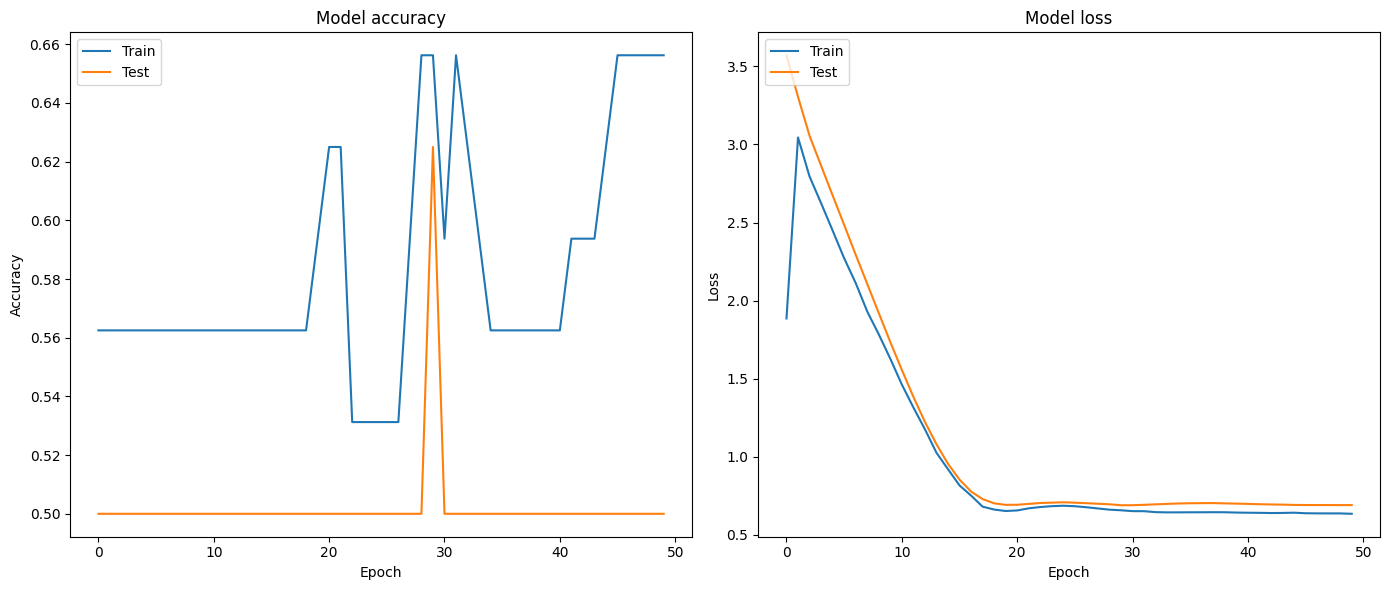

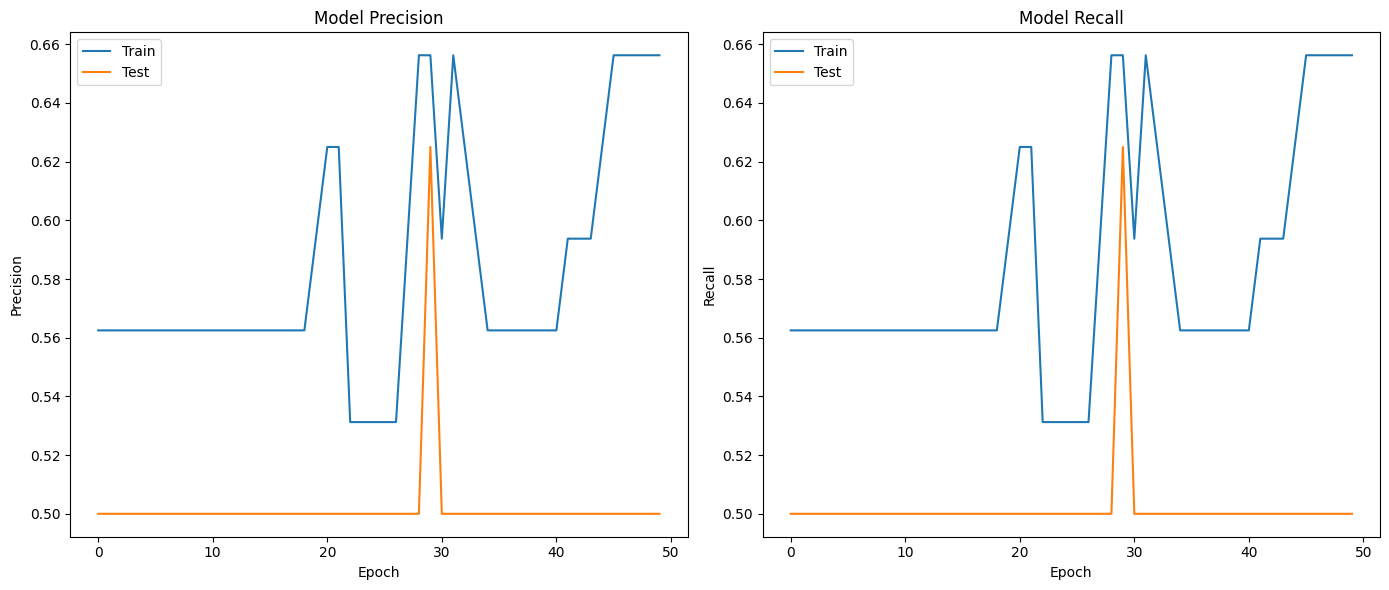

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

# Plot training & validation precision values
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation recall values
plt.subplot(1, 2, 2)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()